In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('accidents_for_classification_model.csv', index_col=0)

df.info()

D:\ProgramFiles\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688794 entries, 0 to 1944329
Data columns (total 38 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   place    1688794 non-null  float64
 1   catu     1688794 non-null  int64  
 2   grav     1688794 non-null  int64  
 3   sexe     1688794 non-null  int64  
 4   secu     1688794 non-null  float64
 5   locp     1688794 non-null  float64
 6   actp     1688794 non-null  float64
 7   etatp    1688794 non-null  float64
 8   senc     1688794 non-null  float64
 9   catv     1688794 non-null  float64
 10  occutc   1688794 non-null  float64
 11  obs      1688794 non-null  float64
 12  obsm     1688794 non-null  float64
 13  choc     1688794 non-null  float64
 14  manv     1688794 non-null  float64
 15  an       1688794 non-null  int64  
 16  mois     1688794 non-null  int64  
 17  jour     1688794 non-null  int64  
 18  hrmn     1688794 non-null  int64  
 19  lum      1688794 non-null  int64  
 20  ag

In [2]:
#df = df.drop(columns=['Num_Acc', 'an', 'mois', 'jour', 'hrmn', 'adr', 'gps', 'lat', 'long', 'com','dep','grav_total', 'date', 'nb_jour', 'vma'])
df.head()

    

,place,catu,grav,sexe,secu,locp,actp,etatp,senc,catv,...,nbv,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,1.0,1,3,1,11.0,0.0,0.0,0.0,0.0,7.0,...,4.0,0.0,1.0,1.0,0.0,150.0,1.0,0.0,1.0,99.0
1,2.0,2,3,2,11.0,0.0,0.0,0.0,0.0,7.0,...,4.0,0.0,1.0,1.0,0.0,150.0,1.0,0.0,1.0,99.0
2,1.0,1,0,2,11.0,0.0,0.0,0.0,0.0,13.0,...,4.0,0.0,1.0,1.0,0.0,150.0,1.0,0.0,1.0,99.0
3,1.0,1,3,2,11.0,0.0,0.0,0.0,0.0,7.0,...,4.0,0.0,1.0,1.0,0.0,80.0,2.0,5.0,1.0,99.0
4,1.0,1,3,2,11.0,0.0,0.0,0.0,0.0,7.0,...,4.0,0.0,1.0,1.0,0.0,80.0,2.0,5.0,1.0,99.0


In [3]:
sampled_df = df.sample(frac=0.3) # Get 100% of the data
len(sampled_df) 

506638

In [4]:

#def grav_class(value):
#    if value == 0:
#        return "No injury"
#    if 0 < value < 7:
#        return "Injured"
#    elif 7 <= value < 13:
#        return "Hospitalised"
#    elif value == 13:
#        return "Killed"#
#
#df['grav_class'] = df['grav_mean'].map(grav_class)

#df = df.drop(columns=['grav_mean'])
#display(df.head(20))    

In [5]:
target=sampled_df['grav']
data=sampled_df.drop('grav', axis=1)

In [6]:
df['grav'].groupby(df['grav']).value_counts()



grav  grav
0     0       733775
3     3       576565
7     7       335216
13    13       43238
Name: grav, dtype: int64

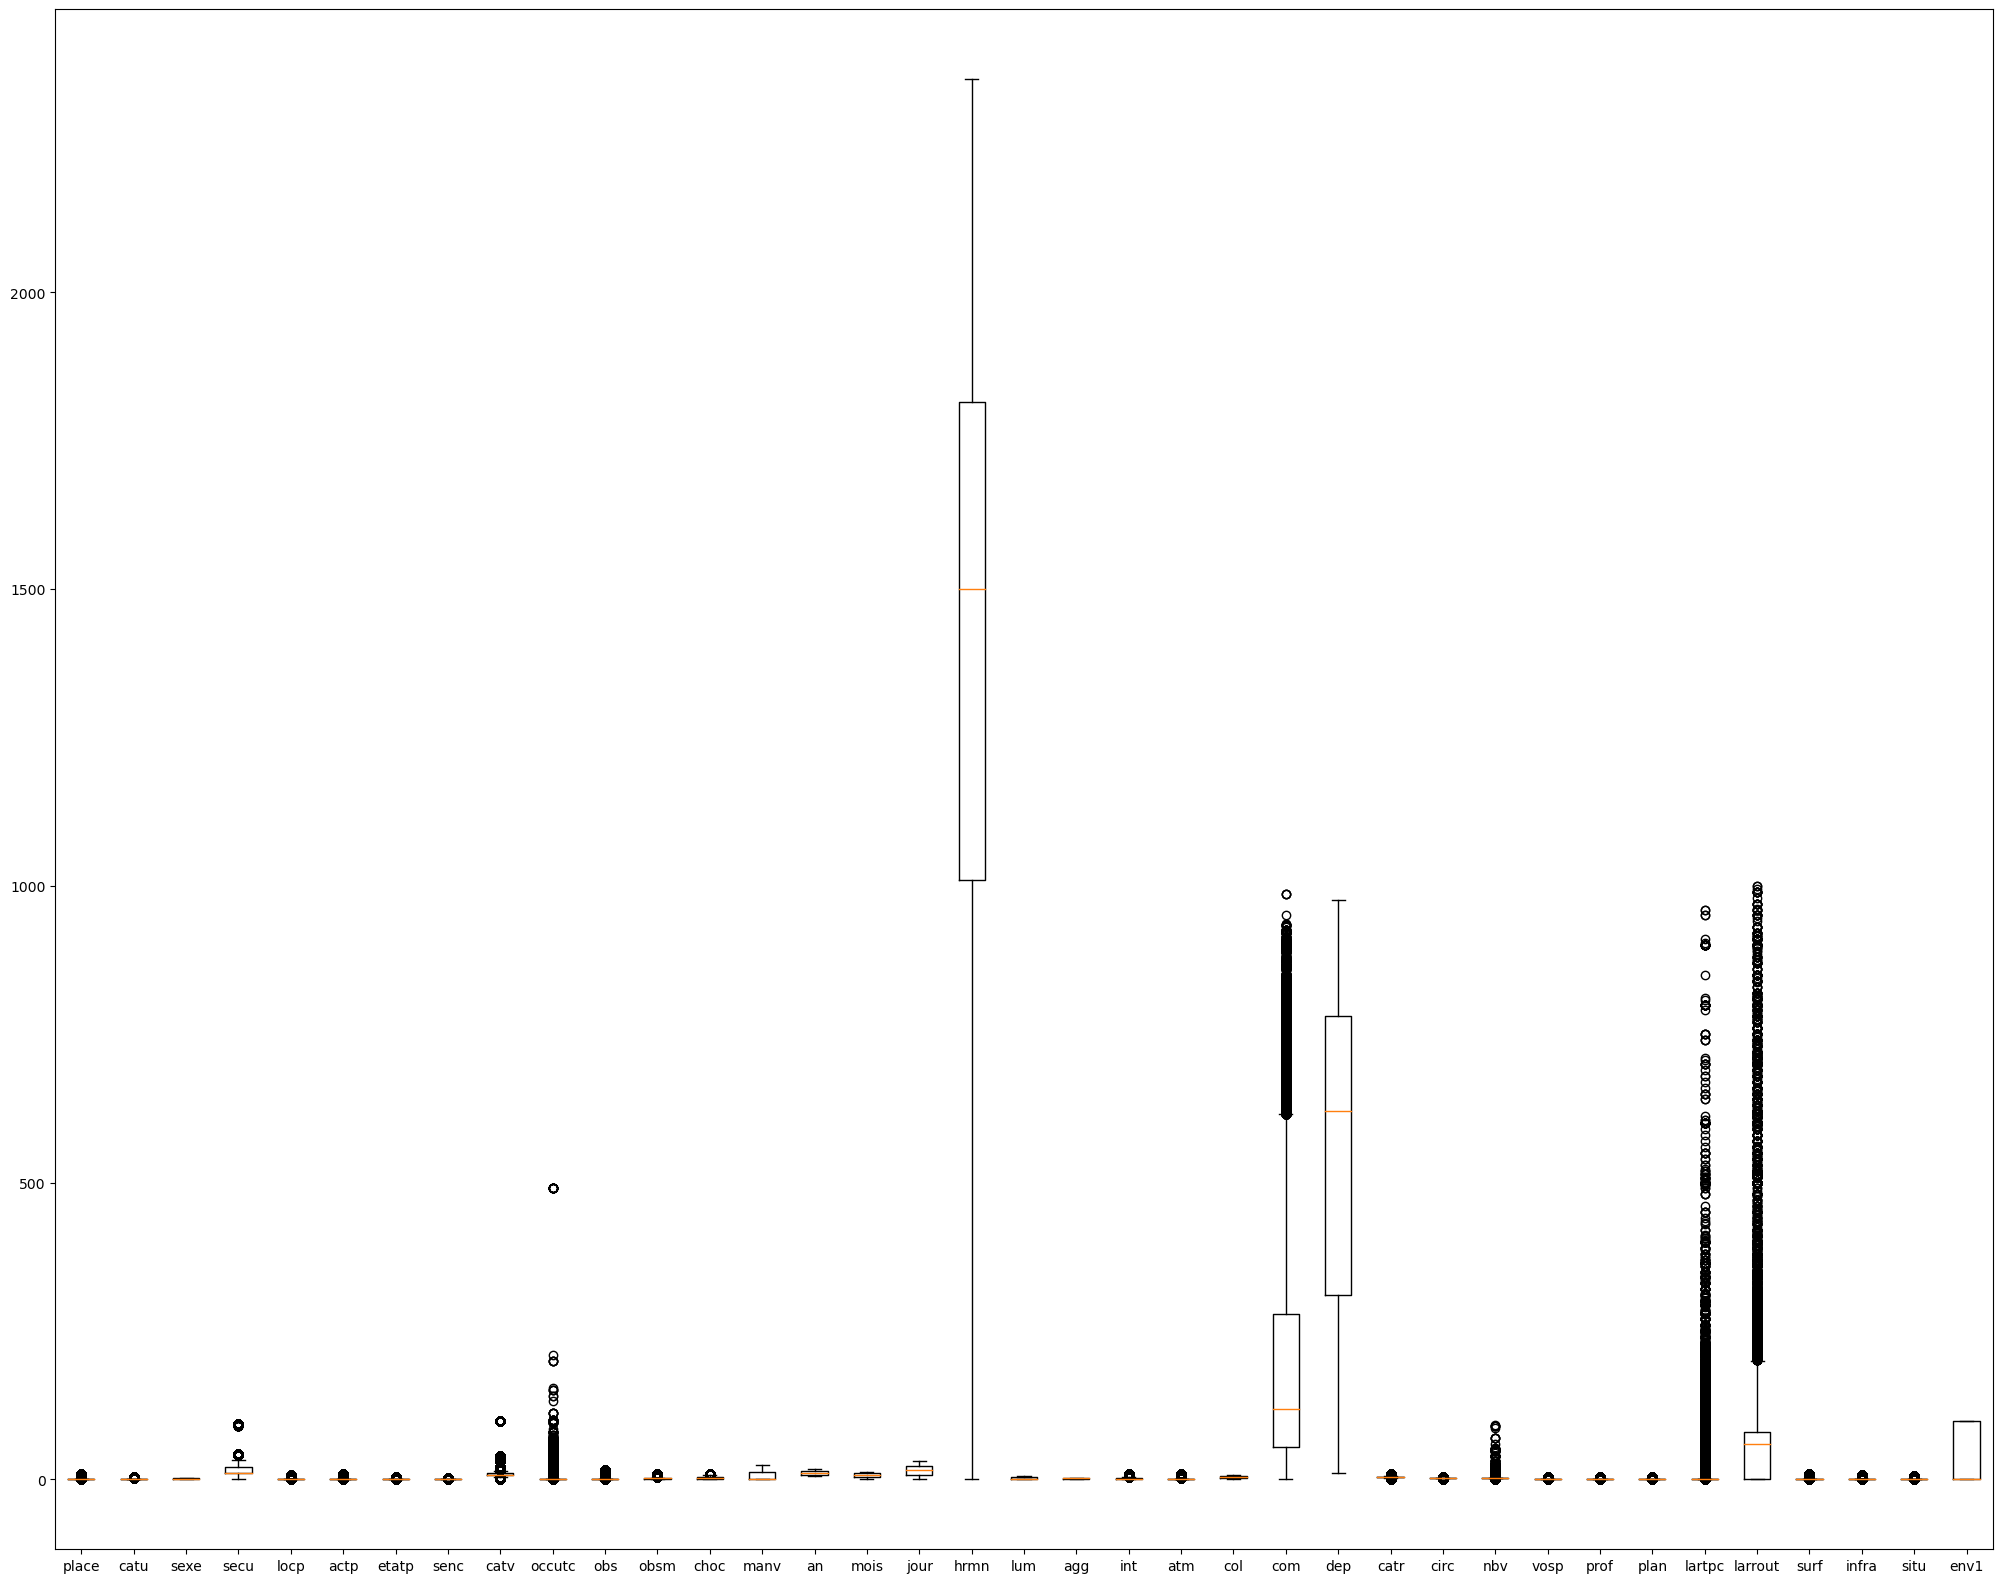

In [7]:
import matplotlib.pyplot as plt

features = list(data.keys())
plt.figure(figsize=(25, 20))
plt.boxplot(data.values,0, labels=features)
plt.show()

,place,catu,sexe,secu,locp,actp,etatp,senc,catv,occutc,...,nbv,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
1302962,0.111111,0.000000,0.0,0.225806,0.000,0.000000,0.000000,0.0,0.295918,0.0,...,0.021978,0.0,0.25,0.25,0.000000,0.060060,0.111111,0.0,0.6,0.0
1515239,0.111111,0.000000,0.0,0.118280,0.000,0.000000,0.000000,0.0,0.091837,0.0,...,0.032967,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.2,0.0
370752,0.000000,0.666667,1.0,0.000000,0.375,0.333333,0.666667,0.0,0.061224,0.0,...,0.021978,0.0,0.25,0.25,0.000000,0.080080,0.111111,0.0,0.2,1.0
1571350,0.333333,0.333333,1.0,0.118280,0.000,0.000000,0.000000,1.0,0.061224,0.0,...,0.032967,0.0,0.50,0.25,0.010417,0.105105,0.111111,0.0,0.6,0.0
10614,0.111111,0.000000,0.0,0.118280,0.000,0.000000,0.000000,0.0,1.000000,0.0,...,0.021978,0.0,0.25,0.25,0.000000,0.075075,0.111111,0.0,0.6,0.0


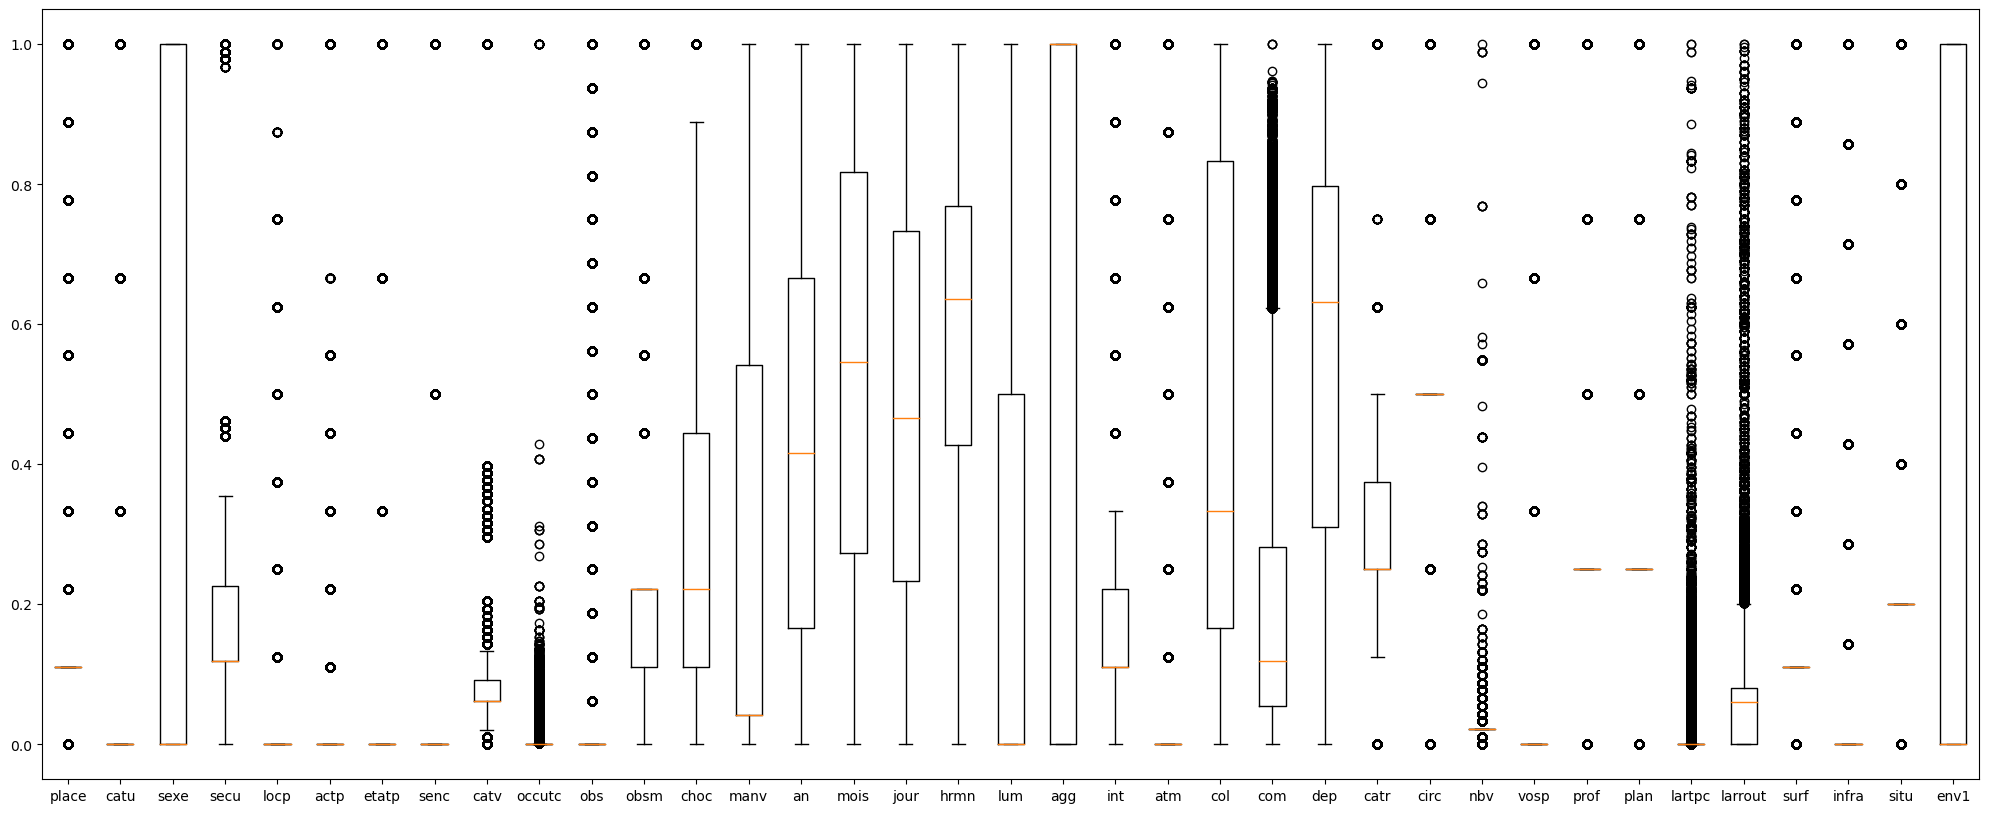

In [8]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(data)
data_scaled=MinMaxScaler.transform(data)

data_scaled=pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
display(data_scaled.head())

features = list(data_scaled.keys())
plt.figure(figsize=(25, 10))
plt.boxplot(data_scaled.values,0,labels=features)
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(data_scaled, target, test_size=0.2, train_size=0.2, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(data_scaled, target, test_size=0.1, train_size=0.1, random_state=150)

In [11]:
#KNN
knn=neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn=knn.predict(X_test)

display(pd.crosstab(y_test, y_pred_knn))
knn.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,16431,4445,1238,35
3,9056,6650,1471,53
7,4693,3219,2025,83
13,543,334,360,28


0.4960918995736618

In [12]:
#SVM 
#from sklearn.svm import SVC
#svc=SVC()
#svc.fit(X_train, y_train)
#y_pred_svc=svc.predict(X_test)
#
#display(pd.crosstab(y_test, y_pred_svc))
#svc.score(X_test, y_test)

#score=0.604

In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc=rfc.predict(X_test)

display(pd.crosstab(y_test, y_pred_rfc))
rfc.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,18730,2553,864,2
3,5240,10205,1783,2
7,2224,3788,3996,12
13,263,236,758,8


0.6501460603189642

In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier

bclf = BalancedRandomForestClassifier()
bclf.fit(X_train, y_train) 
y_pred = bclf.predict(X_test)
pd.crosstab(y_test, y_pred)

bclf.score(X_test, y_test)

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sk

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sk

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sk

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sk

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sk

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sk

D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
D:\ProgramFiles\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


0.5614834991315333

In [15]:
from imblearn.under_sampling import RandomUnderSampler
rUs = RandomUnderSampler()

X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print(dict(pd.Series(y_ru).value_counts()))

#Centroids
#cc = ClusterCentroids()
#X_cc, y_cc = cc.fit_resample(X_train, y_train)
#print(dict(pd.Series(y_cc).value_counts()))



{0: 1287, 13: 1287, 3: 1287, 7: 1287}


In [16]:
#KNN
knn=neighbors.KNeighborsClassifier()
knn.fit(X_ru, y_ru)
y_pred_knn=knn.predict(X_test)

display(pd.crosstab(y_test, y_pred_knn))
knn.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,11908,5444,2644,2153
3,6797,6021,2611,1801
7,2799,2457,2412,2352
13,239,193,330,503


0.4114163903363335

In [17]:
#SVM 
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_ru, y_ru)
y_pred_svc=svc.predict(X_test)
#
display(pd.crosstab(y_test, y_pred_svc))
svc.score(X_test, y_test)



col_0,0,3,7,13
grav,,,,
0,13180,3455,1397,4117
3,4758,7330,1867,3275
7,1540,2646,1571,4263
13,87,116,189,873


0.45306331912205905

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_ru, y_ru)
y_pred_rfc=rfc.predict(X_test)

display(pd.crosstab(y_test, y_pred_rfc))
rfc.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,15701,3022,1658,1768
3,4038,8059,3179,1954
7,1122,2298,3156,3444
13,85,90,274,816


0.5473709142586451

In [19]:
# hyper-parametrs selection

clf_knn = neighbors.KNeighborsClassifier()
clf_rf = RandomForestClassifier()
clf_svc = SVC()

In [20]:
#param_grid_knn = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}
param_grid_knn = {'n_neighbors': np.arange (1,25,1)} 

#param_grid_rf = [{'n_estimators': [2, 5, 10, 50], 
#                  'min_samples_leaf': [1, 3, 5], 
#                  'max_features': ['sqrt', 'log2']}]
param_grid_rf = [{'n_estimators': [2, 4, 6, 8, 10], 
                  'min_samples_leaf': [2, 4, 6, 8,10], 
                  'max_features': ['sqrt']}]
                  #'max_features': ['sqrt', 'log2']}]

#param_grid_svc = [{'C': [0.1, 1, 10, 50], 'kernel': ['rbf', 'linear']}] 
param_grid_svc = [{'C': [0.1, 1, 10], 'kernel': ['linear']}] 

In [21]:
gridcvs = {}

#for pgrid, clf, name in zip((param_grid_knn, param_grid_rf),
#                            (clf_knn, clf_rf),
#                            ('KNN', 'RF')):
#    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
#    gridcvs[name] = gcv    

    

for pgrid, clf, name in zip((param_grid_knn, param_grid_rf, param_grid_svc),
                            (clf_knn, clf_rf, clf_svc),
                            ('KNN', 'RF', 'SVC')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv    
        
    

In [22]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_ru, y_ru, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')


KNN: outer accuracy 39.72 +/- 0.10
RF: outer accuracy 51.13 +/- 1.11
SVC: outer accuracy 43.55 +/- 0.38


In [23]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['RF']
final_clf.fit(X_ru, y_ru)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_ru, y_pred=final_clf.predict(X_ru))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')


Best Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 10}
Training Accuracy: 75.64
Test Accuracy: 52.63


In [24]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506638 entries, 1302962 to 487340
Data columns (total 37 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   place    506638 non-null  float64
 1   catu     506638 non-null  int64  
 2   sexe     506638 non-null  int64  
 3   secu     506638 non-null  float64
 4   locp     506638 non-null  float64
 5   actp     506638 non-null  float64
 6   etatp    506638 non-null  float64
 7   senc     506638 non-null  float64
 8   catv     506638 non-null  float64
 9   occutc   506638 non-null  float64
 10  obs      506638 non-null  float64
 11  obsm     506638 non-null  float64
 12  choc     506638 non-null  float64
 13  manv     506638 non-null  float64
 14  an       506638 non-null  int64  
 15  mois     506638 non-null  int64  
 16  jour     506638 non-null  int64  
 17  hrmn     506638 non-null  int64  
 18  lum      506638 non-null  int64  
 19  agg      506638 non-null  int64  
 20  int      506638 non-

In [25]:

data_dum = pd.get_dummies(data,columns= ['place', 'catu', 'sexe', 'secu', 'locp', 'actp', 'etatp', 'an', 'mois',
       'jour', 'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'com', 'dep', 'catr',
       'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf',
       'infra', 'situ', 'env1', 'senc', 'catv', 'occutc', 'obs', 'obsm',
       'choc', 'manv'], drop_first=True)

print(data_dum.head())

         place_1.0  place_2.0  place_3.0  place_4.0  place_5.0  place_6.0  \
1302962          1          0          0          0          0          0   
1515239          1          0          0          0          0          0   
370752           0          0          0          0          0          0   
1571350          0          0          1          0          0          0   
10614            1          0          0          0          0          0   

         place_7.0  place_8.0  place_9.0  catu_2  ...  manv_15.0  manv_16.0  \
1302962          0          0          0       0  ...          0          0   
1515239          0          0          0       0  ...          0          0   
370752           0          0          0       0  ...          0          0   
1571350          0          0          0       1  ...          0          0   
10614            0          0          0       0  ...          0          0   

         manv_17.0  manv_18.0  manv_19.0  manv_20.0  manv_21.0

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_dum, target, test_size=0.10, train_size=0.10, random_state=150)

In [27]:
#KNN
knn=neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn=knn.predict(X_test)

display(pd.crosstab(y_test, y_pred_knn))
knn.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,17676,3473,978,22
3,6765,8836,1594,35
7,3081,3921,2928,90
13,372,359,503,31


0.5816950892152218

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc=rfc.predict(X_test)

display(pd.crosstab(y_test, y_pred_rfc))
rfc.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,19328,2088,733,0
3,5999,9823,1406,2
7,2605,3811,3595,9
13,285,228,745,7


0.6464748144639192

In [29]:
from imblearn.under_sampling import RandomUnderSampler
rUs = RandomUnderSampler()

X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print(dict(pd.Series(y_ru).value_counts()))


{0: 1287, 13: 1287, 3: 1287, 7: 1287}


In [30]:
knn=neighbors.KNeighborsClassifier()
knn.fit(X_ru, y_ru)
y_pred_knn=knn.predict(X_test)

display(pd.crosstab(y_test, y_pred_knn))
knn.score(X_test, y_test)


col_0,0,3,7,13
grav,,,,
0,15953,3283,1709,1204
3,6045,7133,2770,1282
7,2069,2788,2868,2295
13,174,198,331,562


0.5233696510342649

In [31]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_ru, y_ru)
y_pred_rfc=rfc.predict(X_test)

display(pd.crosstab(y_test, y_pred_rfc))
rfc.score(X_test, y_test)

col_0,0,3,7,13
grav,,,,
0,16894,2236,1197,1822
3,5062,7463,2835,1870
7,1505,2263,2672,3580
13,86,89,227,863


0.5505289752092215

In [32]:
# hyper-parametrs selection

clf_knn = neighbors.KNeighborsClassifier()
clf_rf = RandomForestClassifier()
clf_svc = SVC()

In [33]:
#param_grid_knn = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}
param_grid_knn = {'n_neighbors': np.arange (1,25,1)} 

#param_grid_rf = [{'n_estimators': [2, 5, 10, 50], 
#                  'min_samples_leaf': [1, 3, 5], 
#                  'max_features': ['sqrt', 'log2']}]
param_grid_rf = [{'n_estimators': [2, 4, 6, 8, 10], 
                  'min_samples_leaf': [2, 4, 6, 8,10], 
                  'max_features': ['sqrt']}]
                  #'max_features': ['sqrt', 'log2']}]

#param_grid_svc = [{'C': [0.1, 1, 10, 50], 'kernel': ['rbf', 'linear']}] 
param_grid_svc = [{'C': [0.1, 1, 10], 'kernel': ['linear']}] 

In [34]:
gridcvs = {}

#for pgrid, clf, name in zip((param_grid_knn, param_grid_rf),
#                            (clf_knn, clf_rf),
#                            ('KNN', 'RF')):
#    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
#    gridcvs[name] = gcv    

    

for pgrid, clf, name in zip((param_grid_knn, param_grid_rf, param_grid_svc),
                            (clf_knn, clf_rf, clf_svc),
                            ('KNN', 'RF', 'SVC')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv  

In [35]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_ru, y_ru, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')


KNN: outer accuracy 49.48 +/- 0.94
RF: outer accuracy 49.34 +/- 0.40
SVC: outer accuracy 53.01 +/- 0.20


In [36]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['SVC']
final_clf.fit(X_ru, y_ru)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_ru, y_pred=final_clf.predict(X_ru))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')


Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Training Accuracy: 68.98
Test Accuracy: 56.14
